In [79]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt

import cufflinks as cf
import plotly
import plotly.express as px


from IPython.core.display import HTML
#from wordcloud import WordCloud

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
from collections import OrderedDict 
from colorama import Fore, Back, Style
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize


import unicodedata




In [80]:
data=pd.read_csv("/Users/rebeccaharrison/Documents/Python/Bootcamp/Data/news_articles.csv")
data.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


In [81]:

# some few bits of missing information - so few prob can drop
data=data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2045 entries, 0 to 2045
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2045 non-null   object 
 1   published                2045 non-null   object 
 2   title                    2045 non-null   object 
 3   text                     2045 non-null   object 
 4   language                 2045 non-null   object 
 5   site_url                 2045 non-null   object 
 6   main_img_url             2045 non-null   object 
 7   type                     2045 non-null   object 
 8   label                    2045 non-null   object 
 9   title_without_stopwords  2045 non-null   object 
 10  text_without_stopwords   2045 non-null   object 
 11  hasImage                 2045 non-null   float64
dtypes: float64(1), object(11)
memory usage: 207.7+ KB


In [82]:
# Creating binary outcome variable
data.loc[data['label'] == 'Fake', 'label'] = 1
data.loc[data['label'] == 'Real', 'label'] = 0


In [83]:
# checking out has image
data['hasImage'].value_counts()

1.0    1580
0.0     465
Name: hasImage, dtype: int64

In [84]:
# checking and cleaning author

data.loc[(data['author'] == '-NO AUTHOR-'), 'author'] = 'No Author'
data['author'].value_counts()[:20]


No Author                              527
Activist Post                           82
EdJenner                                73
noreply@blogger.com (Der Postillon)     72
Anonymous                               58
Daniel Greenfield                       55
admin                                   48
Jason Easley                            45
Alex Ansary                             44
Dr. Patrick Slattery                    38
Henry Wolff                             33
Corbett                                 27
tokyowashi (noreply@blogger.com)        20
Mike Rivero                             17
Steve Watson                            16
Sarah Jones                             16
Hrafnkell Haraldsson                    15
Roosh Valizadeh                         15
Letsbereal                              13
ActivistPost                            12
Name: author, dtype: int64

In [85]:
#set date to date
data['date']=pd.to_datetime(data['published'], infer_datetime_format=True, errors='coerce')


In [86]:
# creating a variable that counts no of posts
data['post_no'] = data.groupby('author').cumcount() + 1
data.loc[data['author'] == 'No Author', 'post_no'] = 0
data[['author','post_no','published']]




,author,post_no,published
0,Barracuda Brigade,1,2016-10-26T21:41:00.000+03:00
1,reasoning with facts,1,2016-10-29T08:47:11.259+03:00
2,Barracuda Brigade,2,2016-10-31T01:41:49.479+02:00
3,Fed Up,1,2016-11-01T05:22:00.000+02:00
4,Fed Up,2,2016-11-01T21:56:00.000+02:00
...,...,...,...
2041,Matt Barber,2,2016-10-27T03:04:50.327+03:00
2042,Jane Chastain,2,2016-10-27T03:04:50.704+03:00
2043,Michael Brown,2,2016-10-27T03:04:54.788+03:00
2044,Ann Coulter,3,2016-10-27T03:05:01.989+03:00


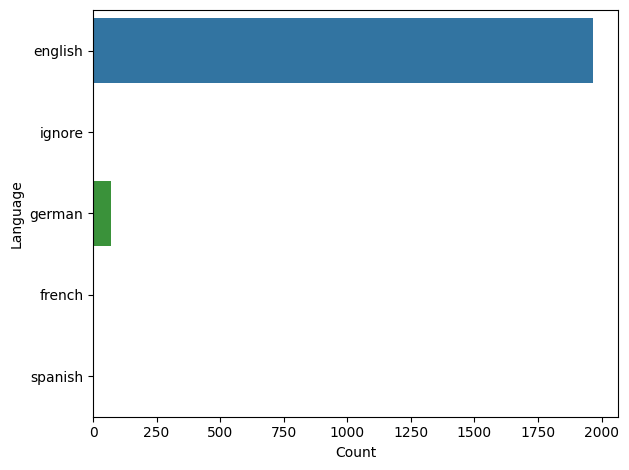

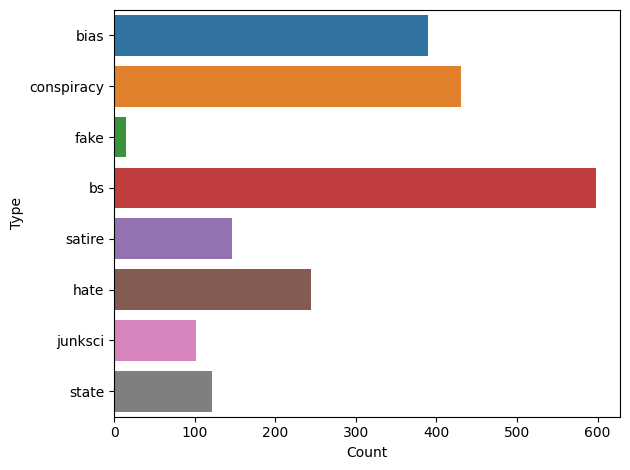

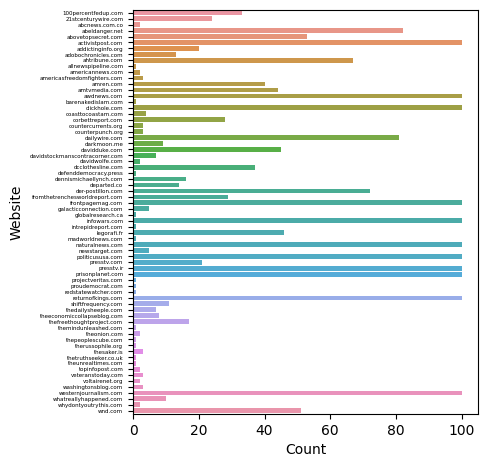

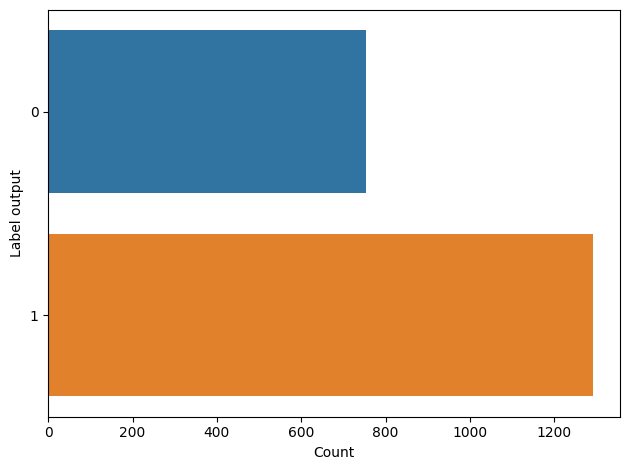

In [87]:
# Bar graphs

bar_chart = sns.countplot(y = 'language',  data = data)
bar_chart.set(xlabel = 'Count', ylabel = 'Language')
plt.tight_layout()
plt.show()

bar_chart = sns.countplot(y = 'type',  data = data)
bar_chart.set(xlabel = 'Count', ylabel = 'Type')
plt.tight_layout()
plt.show()

bar_chart = sns.countplot(y = 'site_url',  data = data)
bar_chart.set(xlabel = 'Count', ylabel = 'Website')
plt.tight_layout()
plt.yticks(fontsize=4)
plt.show()

bar_chart = sns.countplot(y = 'label',  data = data)
bar_chart.set(xlabel = 'Count', ylabel = 'Label output')
plt.tight_layout()
plt.show()


In [88]:
data.head()
data = data.loc[data["language"] == "english" ]


In [89]:
## testing a fake news existing algorithm from here: https://www.kaggle.com/code/ruchi798/how-do-you-recognize-fake-news
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [90]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [91]:
# testing out stemmer and lemmatizer
stemmer=PorterStemmer()
lemmatizer=WordNetLemmatizer()

print("Stemming:" ,stemmer.stem('horrendously'))
print("Lemmatization:" ,lemmatizer.lemmatize('horrendously'))

Stemming: horrend
Lemmatization: horrendously


In [92]:
common_words = get_top_n_words(data['text_without_stopwords'], 20)
df2 = DataFrame (common_words,columns=['word','count'])
df2.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 unigrams used in articles',color='blue')

In [93]:
common_words = get_top_n_bigram(data['text_without_stopwords'], 20)
df3 = pd.DataFrame(common_words, columns = ['words' ,'count'])
df3.groupby('words').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams used in articles', color='blue')

In [94]:
def convert(path):
    return '<img src="'+ path + '" width="80">'

In [95]:
df_sources = data[['site_url','label','main_img_url']]
df_r = df_sources.loc[data['label']== 'Real'].iloc[6:10,:]
df_f = df_sources.loc[data['label']== 'Fake'].head(6)
HTML(df_r.to_html(escape=False,formatters=dict(main_img_url=convert)))

,site_url,label,main_img_url


In [96]:
HTML(df_f.to_html(escape=False,formatters=dict(main_img_url=convert)))

,site_url,label,main_img_url


In [97]:
val_real=[]
val_fake=[]

for i,row in df_sources.iterrows():
    val = row['site_url']
    if row['label'] == 0:
        val_real.append(val)
    elif row['label']== 1:
        val_fake.append(val)

In [98]:
uniqueValues_real = list(OrderedDict.fromkeys(val_real)) 

print(f"Websites publishing real news:{uniqueValues_real}\n") 

Websites publishing real news:['100percentfedup.com', 'addictinginfo.org', 'dailywire.com', 'davidduke.com', 'fromthetrenchesworldreport.com', 'frontpagemag.com', 'newstarget.com', 'politicususa.com', 'presstv.com', 'presstv.ir', 'prisonplanet.com', 'proudemocrat.com', 'redstatewatcher.com', 'returnofkings.com', 'washingtonsblog.com', 'westernjournalism.com', 'whydontyoutrythis.com', 'wnd.com']



In [99]:
uniqueValues_fake = list(OrderedDict.fromkeys(val_fake)) 
print(f"Websites publishing fake news:{uniqueValues_fake}\n")

Websites publishing fake news:['21stcenturywire.com', 'abcnews.com.co', 'abeldanger.net', 'abovetopsecret.com', 'activistpost.com', 'adobochronicles.com', 'ahtribune.com', 'allnewspipeline.com', 'americannews.com', 'americasfreedomfighters.com', 'amren.com', 'amtvmedia.com', 'awdnews.com', 'barenakedislam.com', 'clickhole.com', 'coasttocoastam.com', 'corbettreport.com', 'countercurrents.org', 'counterpunch.org', 'darkmoon.me', 'davidduke.com', 'davidstockmanscontracorner.com', 'davidwolfe.com', 'dcclothesline.com', 'defenddemocracy.press', 'dennismichaellynch.com', 'departed.co', 'fromthetrenchesworldreport.com', 'frontpagemag.com', 'galacticconnection.com', 'globalresearch.ca', 'infowars.com', 'intrepidreport.com', 'legorafi.fr', 'madworldnews.com', 'naturalnews.com', 'newstarget.com', 'presstv.ir', 'prisonplanet.com', 'projectveritas.com', 'returnofkings.com', 'shiftfrequency.com', 'thedailysheeple.com', 'theeconomiccollapseblog.com', 'thefreethoughtproject.com', 'themindunleashed.co

In [100]:
real_set = set(uniqueValues_real) 
fake_set = set(uniqueValues_fake) 

print(f"Websites publishing both real and fake news:{real_set & fake_set}\n")

Websites publishing both real and fake news:{'davidduke.com', 'westernjournalism.com', 'presstv.ir', 'washingtonsblog.com', 'prisonplanet.com', 'newstarget.com', 'fromthetrenchesworldreport.com', 'returnofkings.com', 'frontpagemag.com'}



In [101]:
type1 = {'bias': 0, 'conspiracy': 1,'fake': 2,'bs': 3,'satire': 4, 'hate': 5,'junksci': 6, 'state': 7}
data.type = [type1[item] for item in data.type] 


In [102]:
def plot_bar(df, feat_x, feat_y, normalize=True):
    """ Plot with vertical bars of the requested dataframe and features"""
    
    ct = pd.crosstab(df[feat_x], df[feat_y])
    if normalize == True:
        ct = ct.div(ct.sum(axis=1), axis=0)
    return ct.plot(kind='bar', stacked=True)

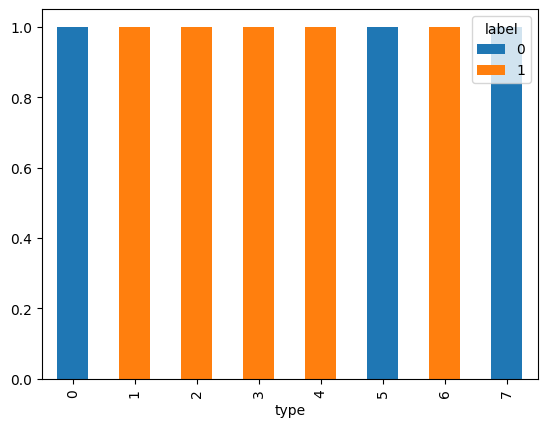

In [103]:
plot_bar(data,'type' , 'label')
plt.show()

In [104]:
y = data.type
# create training data set based on site_url and text

x = data.loc[:,['site_url','text_without_stopwords']]
x['source'] = x["site_url"].astype(str) +" "+ x["text_without_stopwords"] 
x = x.drop(['site_url','text_without_stopwords'],axis=1)
x = x.source
x

0       100percentfedup.com print pay back money plus ...
1       100percentfedup.com attorney general loretta l...
2       100percentfedup.com red state fox news sunday ...
3       100percentfedup.com email kayla mueller prison...
4       100percentfedup.com email healthcare reform ma...
                              ...                        
2041    wnd.com check hillarythemed haunted house anti...
2042    wnd.com good samaritan wearing indian headdres...
2043    wnd.com skype sex scam fortune built shame mor...
2044    wnd.com posted eddie skyhigh potency may scare...
2045    wnd.com billion even known keeping supposedly ...
Name: source, Length: 1967, dtype: object

In [105]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30)
# this is counting the relative frequency of words
tfidf_vect = TfidfVectorizer(stop_words = 'english')
tfidf_train = tfidf_vect.fit_transform(x_train)
tfidf_test = tfidf_vect.transform(x_test)
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vect.get_feature_names())
tfidf_df

,100percentfedup,21stcenturywire,___,_url,aa,aab,aadmi,aaja,aali,aaliya,...,zulutiming,zuma,zusammenzupacken,zwei,zwischen,zz,zünftige,ça,übeltäter,überlegen
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.053052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1372,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1373,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1374,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
logreg = LogisticRegression(solver='liblinear',random_state=0)
logreg.fit(tfidf_train, y_train)
y_pred3 = logreg.predict(tfidf_test)
ABscore = metrics.accuracy_score(y_test,y_pred3)
print("accuracy on test data: %0.3f" %ABscore)
y_pred4 = logreg.predict(tfidf_train)
ABscoret = metrics.accuracy_score(y_train,y_pred4)
print("accuracy on training data: %0.3f" %ABscoret)
# this isn't great

accuracy on test data: 0.563
accuracy on training data: 0.895


In [107]:
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=5,random_state=1)
Adab.fit(tfidf_train, y_train)
y_pred5 = Adab.predict(tfidf_test)
ABscore = metrics.accuracy_score(y_test,y_pred5)
print("accuracy on test data: %0.3f" %ABscore)
y_pred6 = Adab.predict(tfidf_train)
ABscore_t = metrics.accuracy_score(y_train,y_pred6)
print("accuracy on training data: %0.3f" %ABscore_t)
# much better

accuracy on test data: 0.958
accuracy on training data: 0.996


In [108]:
Rando = RandomForestClassifier(n_estimators=100,random_state=0)
Rando.fit(tfidf_train,y_train)
y_pred8 = Rando.predict(tfidf_test)
RFscore = metrics.accuracy_score(y_test,y_pred8)
print("accuracy on test data:  %0.3f" %RFscore)
y_pred7 = Rando.predict(tfidf_train)
RFscorett = metrics.accuracy_score(y_train,y_pred7)
print("accuracy on training data:  %0.3f" %RFscorett)
# not as good

accuracy on test data:  0.851
accuracy on training data:  0.999
